# STOR 320 Introduction to Data Science

## Week 10: Regularization

# Part 1

### Let's first revisit the Ames housing dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
ames = pd.read_csv('Ames.csv')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2930 non-null   int64  
 1   MSZoning       2930 non-null   object 
 2   LotFrontage    2440 non-null   float64
 3   LotArea        2930 non-null   float64
 4   Street         2930 non-null   object 
 5   Alley          2930 non-null   object 
 6   LotShape       2930 non-null   object 
 7   LandContour    2930 non-null   object 
 8   Utilities      2930 non-null   object 
 9   LotConfig      2930 non-null   object 
 10  LandSlope      2930 non-null   object 
 11  Neighborhood   2930 non-null   object 
 12  Condition1     2930 non-null   object 
 13  Condition2     2930 non-null   object 
 14  BldgType       2930 non-null   object 
 15  HouseStyle     2930 non-null   object 
 16  OverallQual    2930 non-null   int64  
 17  OverallCond    2930 non-null   int64  
 18  YearBuil

###  Basic data cleaning and EDA

#### 1.1.1 Dependent Variable

a) A quick visualization of the dependent variable

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

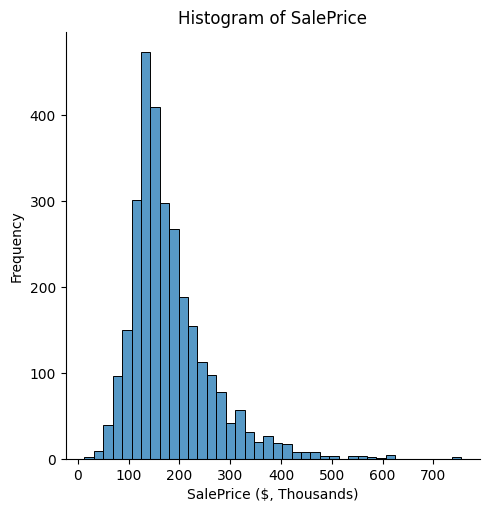

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
plt.figure(figsize=(8,6))
ax = sns.displot(ames['SalePrice']/1000, bins=40)

plt.xlabel('SalePrice ($, Thousands)')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice')

plt.show()
ames['SalePrice'].describe()

b. Log transformation: Let's take log to be more fair in comparing high vs. low price homes.

In [5]:
ames['LogSalePrice'] = ames['SalePrice'].apply(np.log)
ames.drop(columns='SalePrice', inplace=True)

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

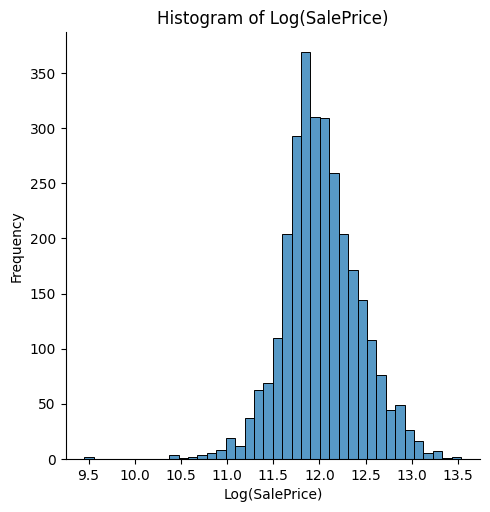

count    2930.000000
mean       12.020969
std         0.407587
min         9.456341
25%        11.771436
50%        11.982929
75%        12.271392
max        13.534473
Name: LogSalePrice, dtype: float64

In [6]:
plt.figure(figsize=(8,6))
ax = sns.displot(ames['LogSalePrice'], bins=40)

plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.title('Histogram of Log(SalePrice)')

plt.show()
ames['LogSalePrice'].describe()

#### 1.1.2 Independent Variables

a) Column Names: One of the column names contains a dot. We rename it to avoid any problem:

In [7]:
ames.rename(columns={'YearRemod.Add':'YearRemodAdd'}, inplace=True)

b) Move the new dependent variable (LogSalePrice) to the first column

In [8]:
ames = ames[[ames.columns[-1]] + list(ames.columns)[:-1] ]
ames

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960.0,1960.0,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,7.0,Typ,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,5.0,2010.0,WD,Normal
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961.0,1961.0,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,NoFirePlace,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NoPool,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958.0,1958.0,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,NoFirePlace,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NoPool,NoFence,Gar2,12500.0,6.0,2010.0,WD,Normal
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968.0,1968.0,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,Ex,8.0,Typ,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,4.0,2010.0,WD,Normal
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997.0,1998.0,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NoPool,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,11.867097,80,RL,37.0,7937.0,Pave,NoAccess,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984.0,1984.0,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003.0,0.0,0.0,1003.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,6.0,Typ,0.0,NoFirePlace,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120.0,0.0,0.0,0.0,0.0,0.0,NoPool,GdPrv,NaN,0.0,3.0,2006.0,WD,Normal
2926,11.782953,20,RL,NaN,8885.0,Pave,NoAccess,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983.0,1983.0,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902.0,0.0,0.0,902.0,1.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,NoFirePlace,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164.0,0.0,0.0,0.0,0.0,0.0,NoPool,MnPrv,NaN,0.0,6.0,2006.0,WD,Normal
2927,11.79

### 1.2 More cleaning: Combine the information from two columns

#### 1.2.1 Fix Condition variables

Convert condition variables into dummy variables. We look at both `Condition1` or `Condition2` to decide which conditions each home belongs to. 

In [9]:
print(np.unique(ames['Condition1']))
print(np.unique(ames['Condition2']))

['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNe' 'RRNn']
['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNn']


In [10]:
condition_dummy=np.unique(ames['Condition1'])
# In the line above, we implicitly treate 'Norm' as the reference level
ames[condition_dummy]=0

for i in condition_dummy:
    print(i)
    ames.loc[(ames['Condition1']==i) | (ames['Condition2']==i), i]=1

ames.drop(columns=['Condition1', 'Condition2'], inplace=True)

Artery
Feedr
Norm
PosA
PosN
RRAe
RRAn
RRNe
RRNn


In [11]:
ames.loc[:,['Artery', 'Feedr', 'Norm']]

,Artery,Feedr,Norm
0,0,0,1
1,0,1,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2925,0,0,1
2926,0,0,1
2927,0,0,1
2928,0,0,1


#### 1.2.2 Encode Exterior Variables 

Same treatment as with condition variables

In [12]:
print(np.unique(ames['Exterior1st']))
print(np.unique(ames['Exterior2nd']))

['AsbShng' 'AsphShn' 'BrkComm' 'BrkFace' 'CBlock' 'CemntBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Plywood' 'PreCast' 'Stone' 'Stucco' 'VinylSd'
 'Wd Sdng' 'WdShing']
['AsbShng' 'AsphShn' 'Brk Cmn' 'BrkFace' 'CBlock' 'CmentBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Other' 'Plywood' 'PreCast' 'Stone' 'Stucco'
 'VinylSd' 'Wd Sdng' 'Wd Shng']


In [13]:
# Remove the space in each level to avoid errors in column names later on.
ames['Exterior1st'] = ames['Exterior1st'].str.replace(' ','')
ames['Exterior2nd'] = ames['Exterior2nd'].str.replace(' ','')
print(np.unique(ames['Exterior1st']))
print(np.unique(ames['Exterior2nd']))

['AsbShng' 'AsphShn' 'BrkComm' 'BrkFace' 'CBlock' 'CemntBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Plywood' 'PreCast' 'Stone' 'Stucco' 'VinylSd'
 'WdSdng' 'WdShing']
['AsbShng' 'AsphShn' 'BrkCmn' 'BrkFace' 'CBlock' 'CmentBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Other' 'Plywood' 'PreCast' 'Stone' 'Stucco'
 'VinylSd' 'WdSdng' 'WdShng']


In [14]:
np.unique(np.concatenate((np.unique(ames['Exterior1st']),np.unique(ames['Exterior2nd'])), axis=0 )) 

array(['AsbShng', 'AsphShn', 'BrkCmn', 'BrkComm', 'BrkFace', 'CBlock',
       'CemntBd', 'CmentBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other',
       'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'WdSdng',
       'WdShing', 'WdShng'], dtype=object)

In [15]:
exterior_dummy=np.unique(np.concatenate((np.unique(ames['Exterior1st']),np.unique(ames['Exterior2nd'])), axis=0 )) 
ames[exterior_dummy]=0

for i in exterior_dummy:
    print(i)
    ames.loc[(ames['Exterior1st']==i) | (ames['Exterior2nd']==i), i]=1

ames.drop(columns=['Exterior1st', 'Exterior2nd'], inplace=True)

AsbShng
AsphShn
BrkCmn
BrkComm
BrkFace
CBlock
CemntBd
CmentBd
HdBoard
ImStucc
MetalSd
Other
Plywood
PreCast
Stone
Stucco
VinylSd


WdSdng
WdShing
WdShng


### 1.3 Create New Features for Year Built & Year Remodeled

Let's see how sale price is affected by the year built and the year remodeled.

In [16]:
print(ames['YearBuilt'].describe(), '\n')
print(ames['YearRemodAdd'].describe())

count    2930.000000
mean     1971.356314
std        30.245361
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2001.000000
max      2010.000000
Name: YearBuilt, dtype: float64 

count    2930.000000
mean     1984.266553
std        20.860286
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


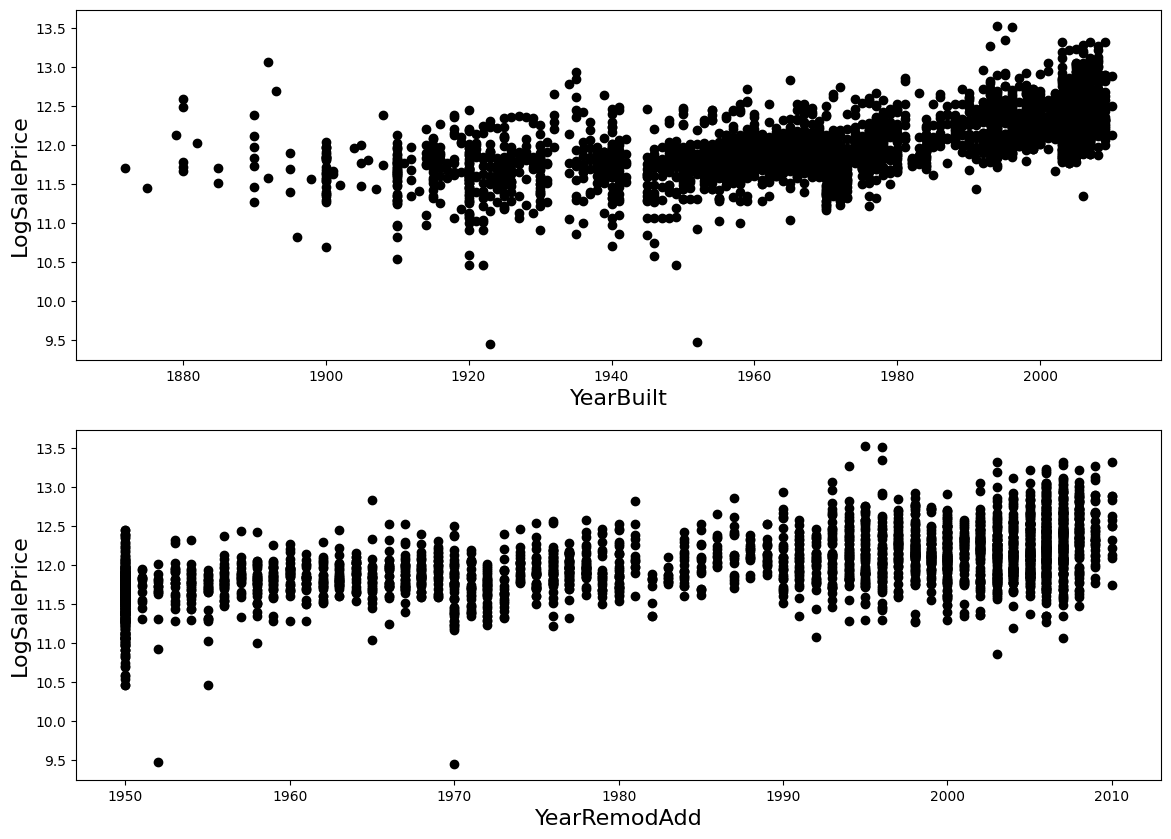

In [17]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.scatter(ames['YearBuilt'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('YearBuilt', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)

plt.subplot(2,1,2)
plt.scatter(ames['YearRemodAdd'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('YearRemodAdd', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)
plt.show()

#### Let's add features:
* `YearsSince1950Built` -- number of years after 1950 that the home was built (if before 1950, set to 0)
* `YearsSince1950Remod` -- number of years after 1950 that the home was remodeled

In [18]:
ames['YearsSince1950Built'] = (np.clip(ames['YearBuilt']-1950,0,np.nan)).astype('int')
ames['YearsSince1950Remod'] = (np.clip(ames['YearRemodAdd']-1950,0,np.nan)).astype('int')

ames.drop(columns=['YearBuilt', 'YearRemodAdd'], inplace=True)

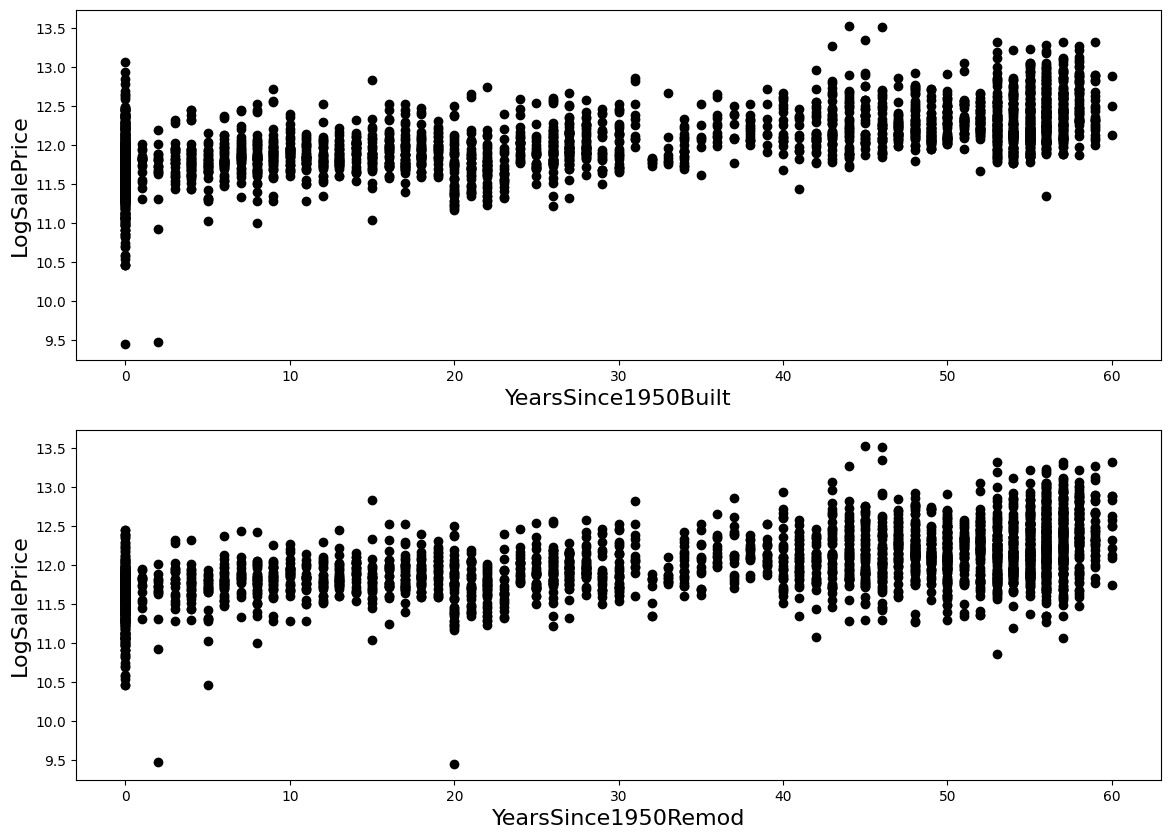

In [19]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.scatter(ames['YearsSince1950Built'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('YearsSince1950Built', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)

plt.subplot(2,1,2)
plt.scatter(ames['YearsSince1950Remod'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('YearsSince1950Remod', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)
plt.show()

### 1.4 Remove Outliers and Mistakes

Text(0, 0.5, 'LogSalePrice')

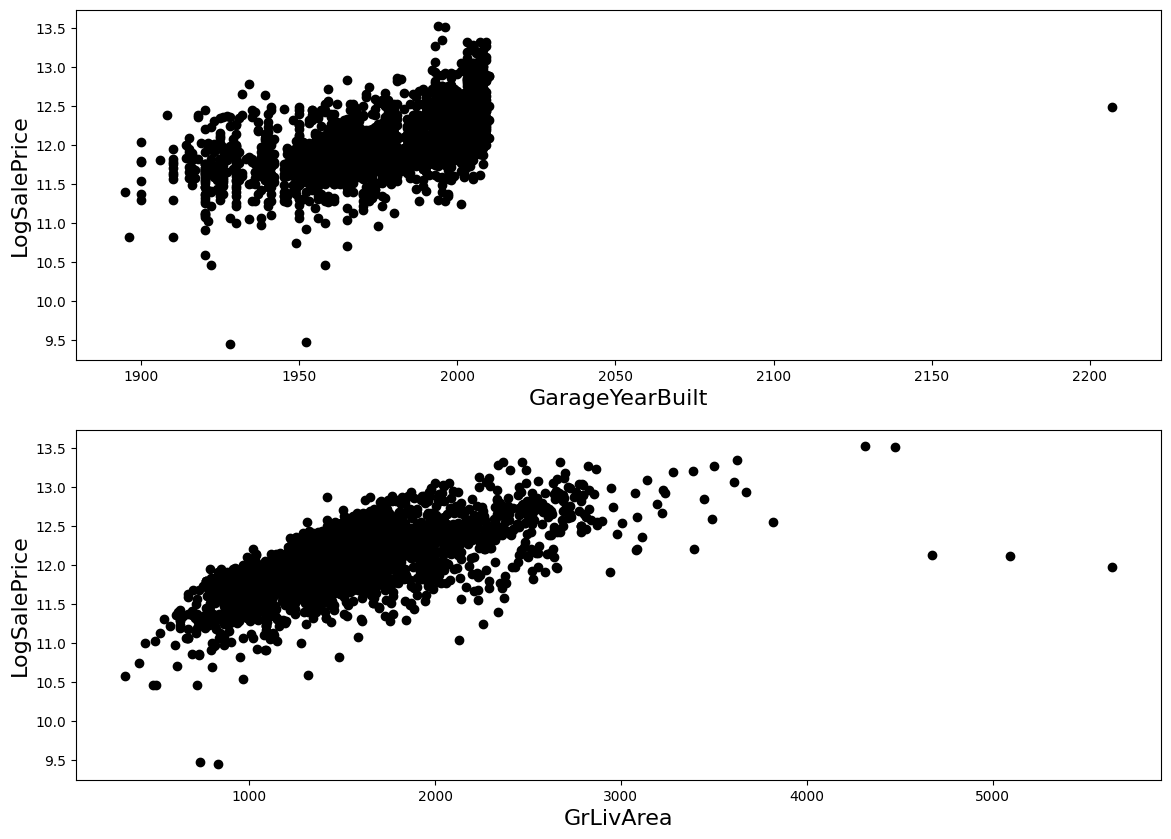

In [20]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.scatter(ames['GarageYrBlt'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('GarageYearBuilt', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)

plt.subplot(2,1,2)
plt.scatter(ames['GrLivArea'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('GrLivArea', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)

a) Throw away outliers and mistakes:

In [21]:
ames

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsbShng,AsphShn,BrkCmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,5,Hip,CompShg,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,7.0,Typ,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,5.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,5,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,NoFirePlace,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NoPool,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,11
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,6,Hip,CompShg,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,NoFirePlace,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NoPool,NoFence,Gar2,12500.0,6.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,8
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,7,5,Hip,CompShg,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,Ex,8.0,Typ,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,4.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,18
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,5,5,Gable,CompShg,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NoPool,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,11.867097,80,RL,37.0,7937.0,Pave,NoAccess,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,1Fam,SLvl,6,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003.0,0.0,0.0,1003.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,6.0,Typ,0.0,NoFirePlace,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120.0,0.0,0.0,0.0,0.0,0.0,NoPool,GdPrv,NaN,0.0,3.0,2006.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34,34
29

In [22]:
ames.loc[~(ames['GrLivArea']>4000)] # drop 5 obs

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsbShng,AsphShn,BrkCmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,5,Hip,CompShg,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,7.0,Typ,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,5.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,5,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,NoFirePlace,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NoPool,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,11
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,6,Hip,CompShg,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,NoFirePlace,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NoPool,NoFence,Gar2,12500.0,6.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,8
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,7,5,Hip,CompShg,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,Ex,8.0,Typ,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,4.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,18
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,5,5,Gable,CompShg,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NoPool,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,11.867097,80,RL,37.0,7937.0,Pave,NoAccess,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,1Fam,SLvl,6,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003.0,0.0,0.0,1003.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,6.0,Typ,0.0,NoFirePlace,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120.0,0.0,0.0,0.0,0.0,0.0,NoPool,GdPrv,NaN,0.0,3.0,2006.0,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34,34
29

In [23]:
ames = ames.loc[(ames['GarageYrBlt']<=2015)] # drop 1 obs
ames = ames.loc[~(ames['GrLivArea']>4000)] # drop 4 additional obs

Text(0, 0.5, 'LogSalePrice')

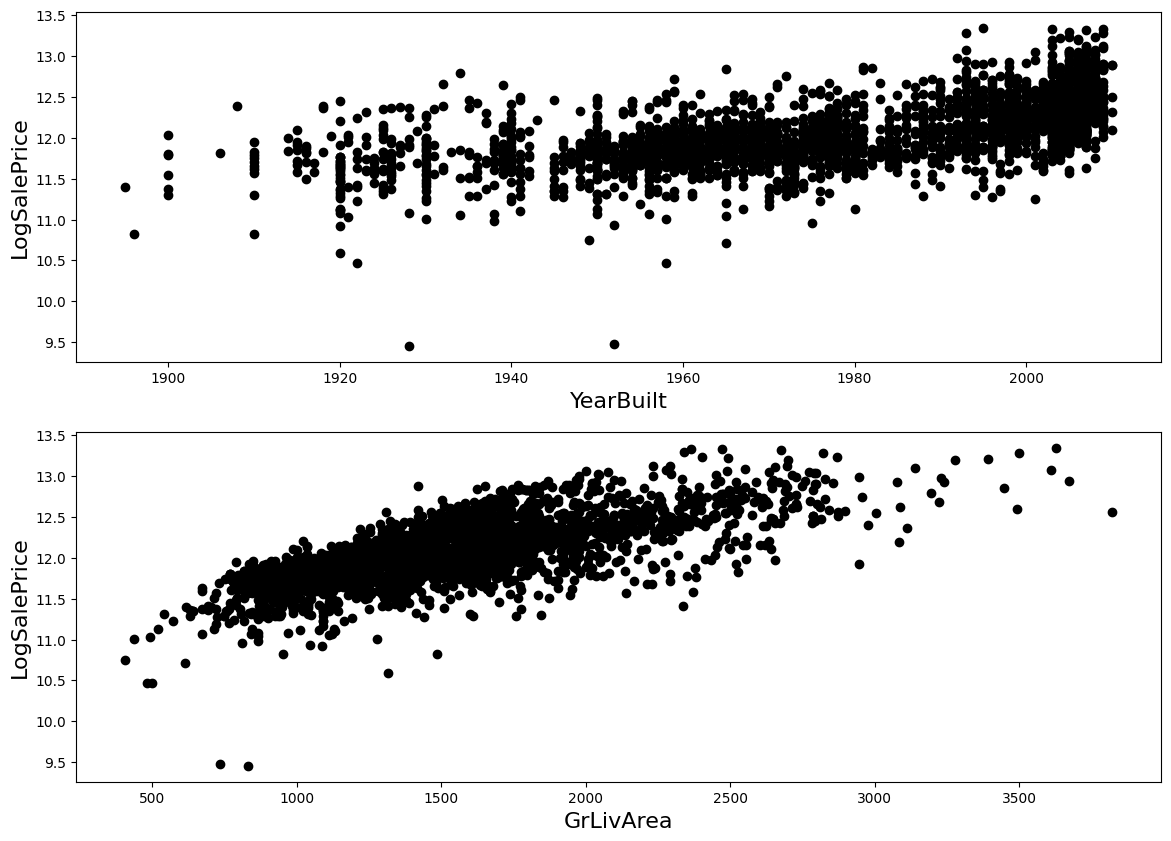

In [24]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.scatter(ames['GarageYrBlt'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('YearBuilt', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)

plt.subplot(2,1,2)
plt.scatter(ames['GrLivArea'].to_numpy(), ames['LogSalePrice'].to_numpy(), color='black')  
plt.xlabel('GrLivArea', fontsize=16)
plt.ylabel('LogSalePrice', fontsize=16)

b) Let's apply the same 1950 transformation to `GarageYrBlt`.

In [25]:
ames['YearsSince1950GarageBuilt'] = (np.clip(ames['GarageYrBlt']-1950,0,np.nan))
ames.drop(columns=['GarageYrBlt'], inplace=True)

### 1.5 Numerical variables to categorical variables (Time Sold and Quality Score)

#### 1.5.1 Time Sold:
    
Investigate further the time when the house was sold:

In [26]:
ames[['YrSold','MoSold']]=ames[['YrSold','MoSold']].astype('int')

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Figure size 600x400 with 0 Axes>

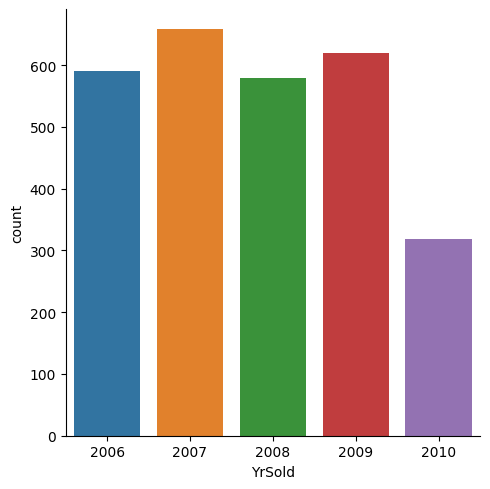

In [27]:
plt.figure(figsize=(6,4))
sns.catplot(x="YrSold", kind="count",data=ames);

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

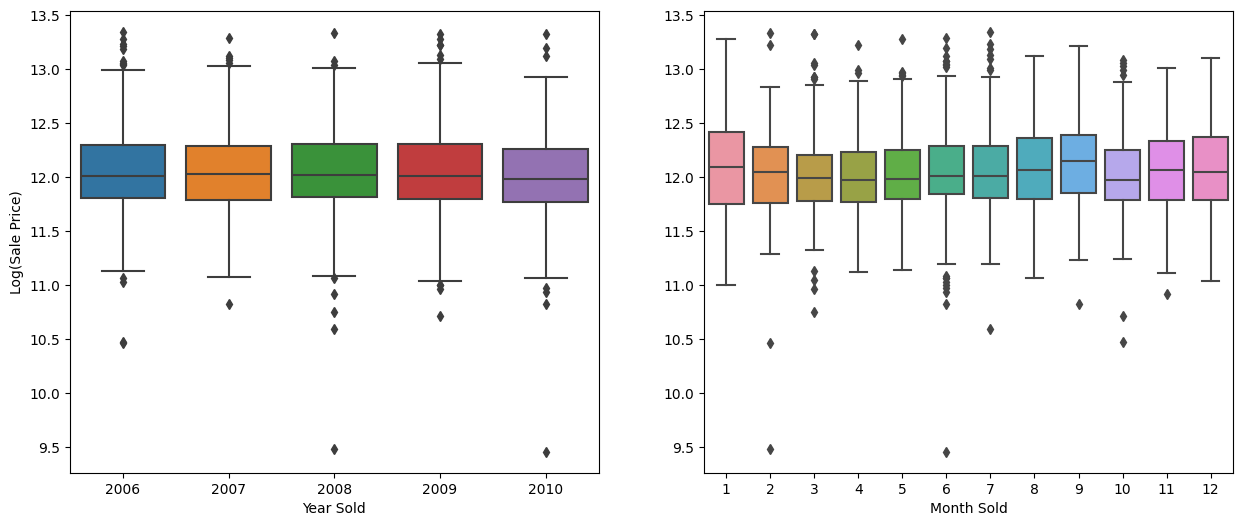

In [28]:
fig, axs=plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x="YrSold", y="LogSalePrice", data=ames, ax= axs[0])
sns.boxplot(x="MoSold", y="LogSalePrice", data=ames, ax= axs[1])
axs[0].set_xlabel('Year Sold')
axs[1].set_xlabel('Month Sold')
axs[0].set_ylabel('Log(Sale Price)')
axs[1].set_ylabel('')
plt.show()

Convert `YrSold` and `MoSold` to categorical variables:

In [29]:
ames[['YrSold','MoSold']]=ames[['YrSold','MoSold']].astype('category')

#### 1.5.2 Quality Variables

Let's look at the overall quality/condition variables.

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

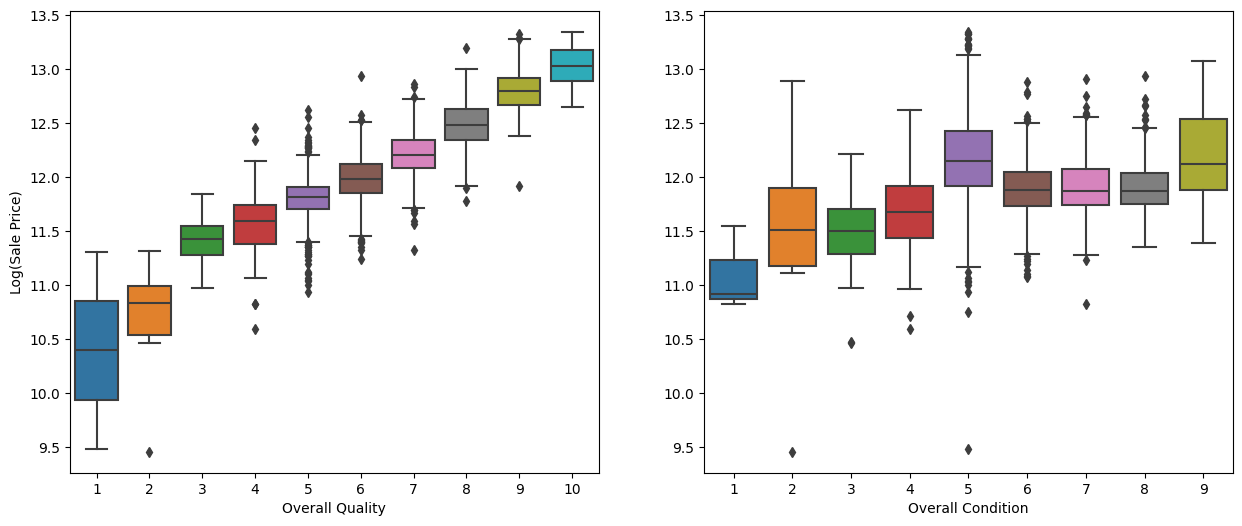

In [30]:
fig, axs=plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x="OverallQual", y="LogSalePrice", data=ames, ax= axs[0])
sns.boxplot(x="OverallCond", y="LogSalePrice", data=ames, ax= axs[1])
axs[0].set_xlabel('Overall Quality')
axs[1].set_xlabel('Overall Condition')
axs[0].set_ylabel('Log(Sale Price)')
axs[1].set_ylabel('')
plt.show()

Let's encode them to categorical:

In [31]:
ames[['OverallQual','OverallCond']]=ames[['OverallQual','OverallCond']].astype('category')

### 1.6 Handling NaN Values

In [32]:
np.sum(ames.isnull(),axis=0)

LogSalePrice                    0
MSSubClass                      0
MSZoning                        0
LotFrontage                   479
LotArea                         0
Street                          0
Alley                           0
LotShape                        0
LandContour                     0
Utilities                       0
LotConfig                       0
LandSlope                       0
Neighborhood                    0
BldgType                        0
HouseStyle                      0
OverallQual                     0
OverallCond                     0
RoofStyle                       0
RoofMatl                        0
MasVnrType                   1629
MasVnrArea                     21
ExterQual                       0
ExterCond                       0
Foundation                      0
BsmtQual                        1
BsmtCond                        1
BsmtExposure                    4
BsmtFinType1                    1
BsmtFinSF1                      1
BsmtFinType2  

# In-class activity 1: Only display the column names with missing values

In [33]:
missing_value = np.sum(ames.isnull(),axis=0)
missing_value[missing_value>0]

LotFrontage      479
MasVnrType      1629
MasVnrArea        21
BsmtQual           1
BsmtCond           1
BsmtExposure       4
BsmtFinType1       1
BsmtFinSF1         1
BsmtFinType2       2
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
MiscFeature     2668
dtype: int64

Dealing with NA columns:

* For numerical variables, NAs arise because some factor has already been set to 0 (e.g., there is no basement), so we convert NAs to 0.

* For categorical variables, we add a new level corresponding to whether the variable is missing from that observation. We'll do this via dummy encoding as usual.


In [34]:
# numerical ones:
numerical_cols = ['LotFrontage', 'MasVnrArea','BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 
                  'BsmtHalfBath', 'GarageCars', 'GarageArea', 'GrLivArea','YearsSince1950GarageBuilt']
for var in numerical_cols:
    print(var, ames[var].dtype)
    ames.loc[np.isnan(ames[var]), [var]] = 0

LotFrontage float64
MasVnrArea float64
BsmtFinSF1 float64
BsmtFinSF2 float64
BsmtUnfSF float64
TotalBsmtSF float64
BsmtFullBath float64
BsmtHalfBath float64
GarageCars float64
GarageArea float64
GrLivArea float64
YearsSince1950GarageBuilt float64


In [35]:
ames['MasVnrType'].dtype

dtype('O')

In [36]:
# categorical ones:
categorical_cols = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'Electrical', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature']

for var in categorical_cols:
    print(var, ames[var].dtype)
    ames.loc[(ames[var]).isna(), [var]] = 'NaN'

ames[categorical_cols]=ames[categorical_cols].astype('category')

MasVnrType object
BsmtQual object
BsmtCond object
BsmtExposure object
BsmtFinType1 object
BsmtFinType2 object
Electrical object
GarageFinish object
GarageQual object
GarageCond object
MiscFeature object


In [37]:
# check again:
print(np.sum(ames.isnull().any()))

0


### 1.7 Some More EDA

### 1.7.1 Continuous variables

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: xlabel='GarageArea', ylabel='LogSalePrice'>

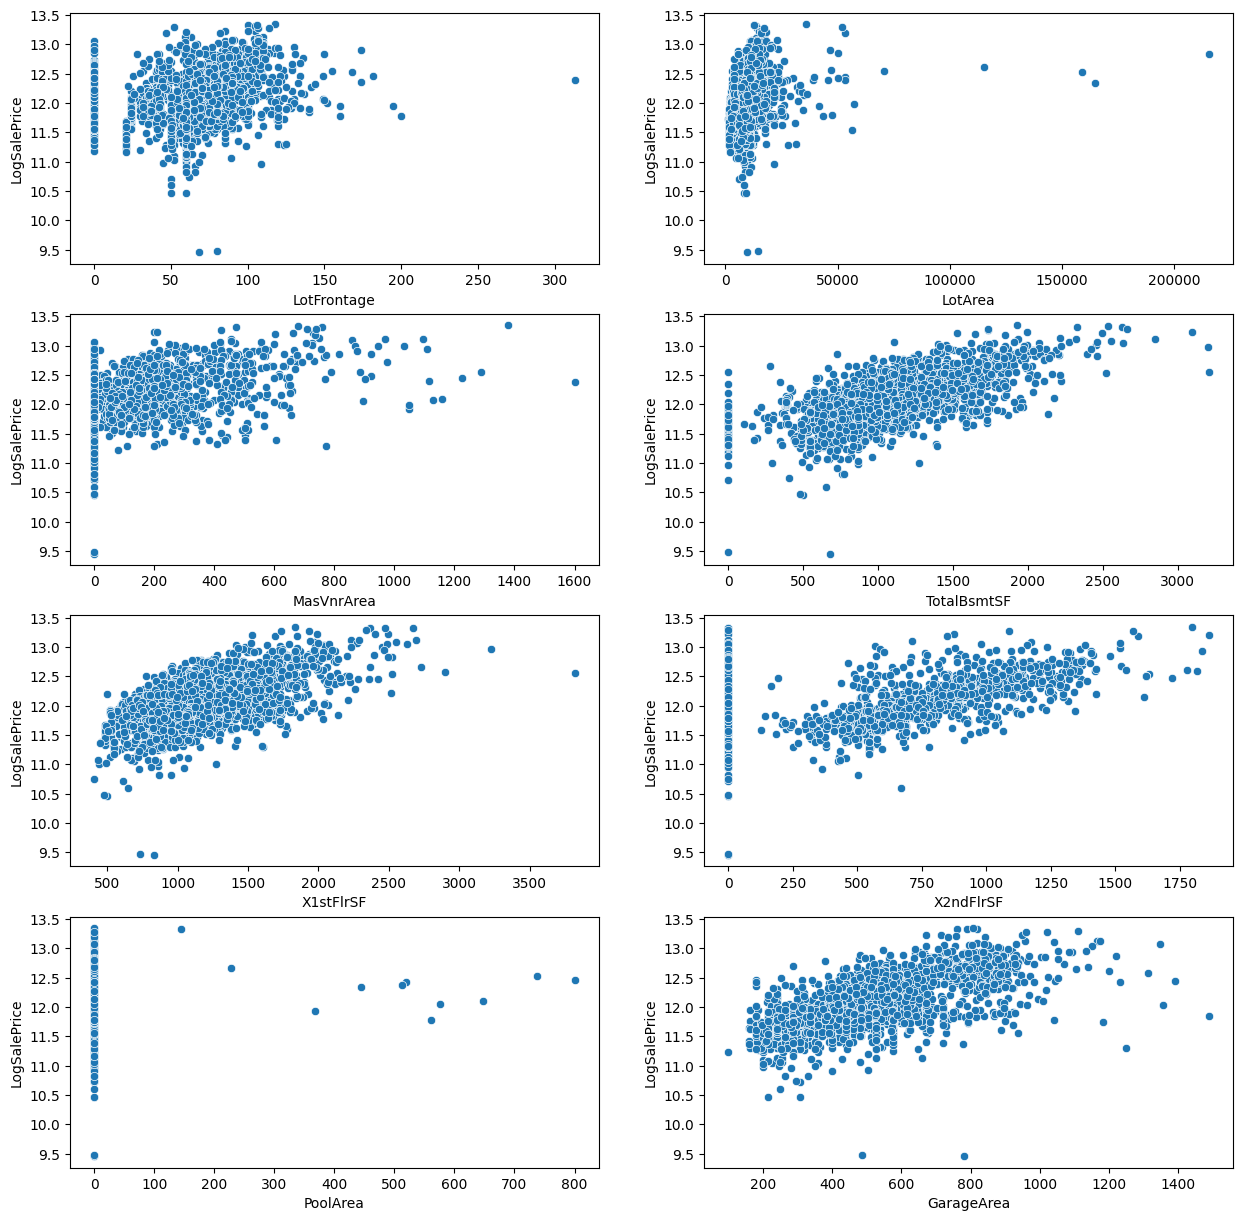

In [38]:
# a) Scattered plots
fig, axs=plt.subplots(4,2, figsize=(15,15))
sns.scatterplot(data=ames, x="LotFrontage", y="LogSalePrice", ax= axs[0,0])
sns.scatterplot(data=ames, x="LotArea", y="LogSalePrice", ax= axs[0,1])
sns.scatterplot(data=ames, x="MasVnrArea", y="LogSalePrice", ax= axs[1,0])
sns.scatterplot(data=ames, x="TotalBsmtSF", y="LogSalePrice", ax= axs[1,1])
sns.scatterplot(data=ames, x="X1stFlrSF", y="LogSalePrice", ax= axs[2,0])
sns.scatterplot(data=ames, x="X2ndFlrSF", y="LogSalePrice", ax= axs[2,1])
sns.scatterplot(data=ames, x="PoolArea", y="LogSalePrice", ax= axs[3,0])
sns.scatterplot(data=ames, x="GarageArea", y="LogSalePrice", ax= axs[3,1])

<Axes: xlabel='GarageArea', ylabel='LogSalePrice'>

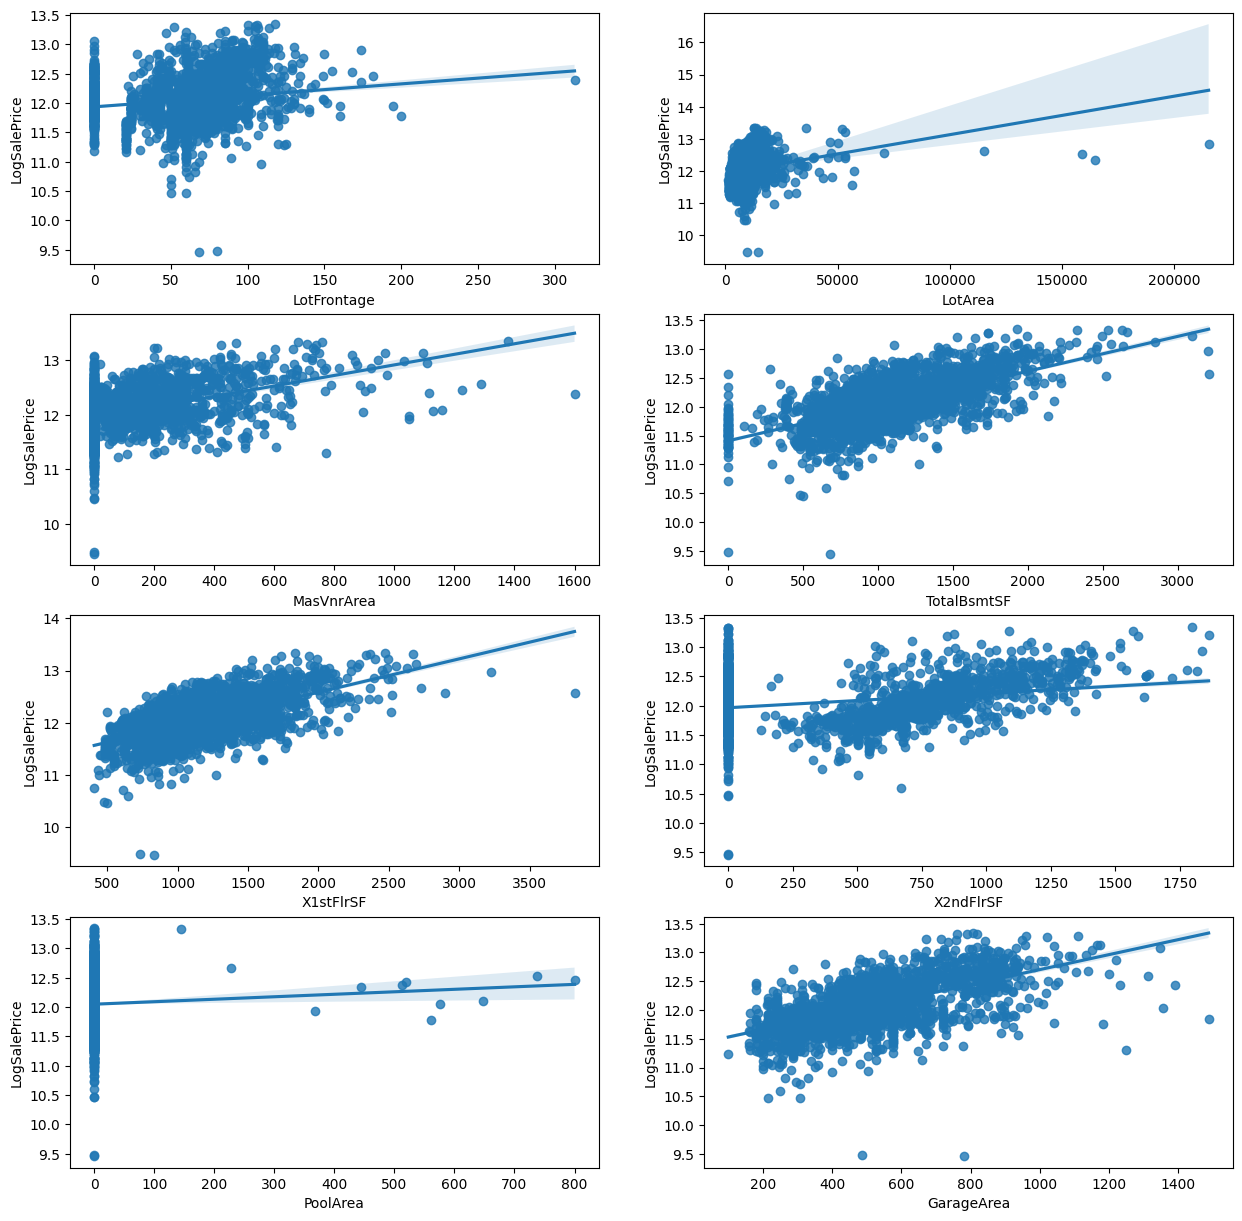

In [39]:
# b) Smoothed versions of those plots (with a trend line).
fig, axs=plt.subplots(4,2, figsize=(15,15))
sns.regplot(data=ames, x="LotFrontage", y="LogSalePrice", ax= axs[0,0])
sns.regplot(data=ames, x="LotArea", y="LogSalePrice", ax= axs[0,1])
sns.regplot(data=ames, x="MasVnrArea", y="LogSalePrice", ax= axs[1,0])
sns.regplot(data=ames, x="TotalBsmtSF", y="LogSalePrice", ax= axs[1,1])
sns.regplot(data=ames, x="X1stFlrSF", y="LogSalePrice", ax= axs[2,0])
sns.regplot(data=ames, x="X2ndFlrSF", y="LogSalePrice", ax= axs[2,1])
sns.regplot(data=ames, x="PoolArea", y="LogSalePrice", ax= axs[3,0])
sns.regplot(data=ames, x="GarageArea", y="LogSalePrice", ax= axs[3,1])


Note: It appears that there are nonlinear relationships. Later, we will use polynomials to enhance our models. 

### 1.7.2 Discrete Variables

Let's look at discrete variables now.

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: xlabel='GarageCars', ylabel='LogSalePrice'>

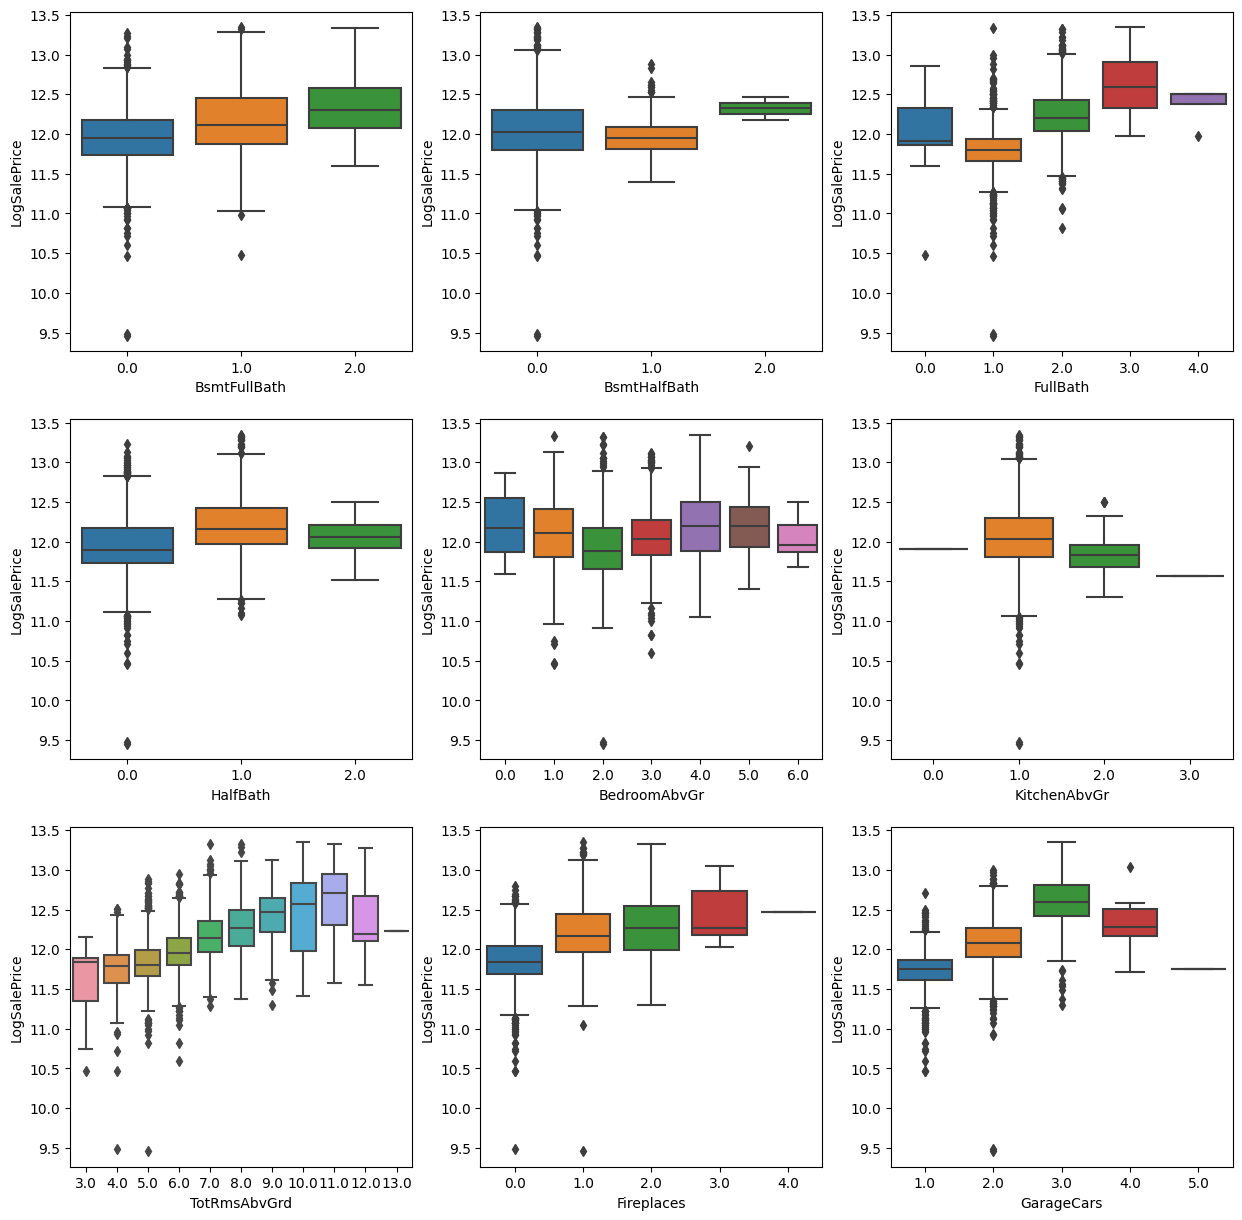

In [40]:
fig, axs=plt.subplots(3,3, figsize=(15,15))
sns.boxplot(data=ames, x="BsmtFullBath", y="LogSalePrice", ax= axs[0,0])
sns.boxplot(data=ames, x="BsmtHalfBath", y="LogSalePrice", ax= axs[0,1])
sns.boxplot(data=ames, x="FullBath", y="LogSalePrice", ax= axs[0,2])
sns.boxplot(data=ames, x="HalfBath", y="LogSalePrice", ax= axs[1,0])
sns.boxplot(data=ames, x="BedroomAbvGr", y="LogSalePrice", ax= axs[1,1])
sns.boxplot(data=ames, x="KitchenAbvGr", y="LogSalePrice", ax= axs[1,2])
sns.boxplot(data=ames, x="TotRmsAbvGrd", y="LogSalePrice", ax= axs[2,0])
sns.boxplot(data=ames, x="Fireplaces", y="LogSalePrice", ax= axs[2,1])
sns.boxplot(data=ames, x="GarageCars", y="LogSalePrice", ax= axs[2,2])


Let's convert those all to factors.

In [41]:
discrete_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MSSubClass']
ames[discrete_cols] = ames[discrete_cols].astype('int').astype('category')

### 1.7.3 Other Categorical Variables

We still have many columns that are categorical. We must encode them before passing them to our models

In [42]:
still_categorical = ames.columns[ames.dtypes == 'object']
for col in still_categorical:
    print(col, ':\n', ames[col].unique())

MSZoning :
 ['RL' 'RH' 'FV' 'RM' 'C' 'I' 'A']
Street :
 ['Pave' 'Grvl']
Alley :
 ['NoAccess' 'Pave' 'Grvl']
LotShape :
 ['IR1' 'Reg' 'IR2' 'IR3']
LandContour :
 ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities :
 ['AllPub' 'NoSewr' 'NoSeWa']
LotConfig :
 ['Corner' 'Inside' 'CulDSac' 'FR2' 'FR3']
LandSlope :
 ['Gtl' 'Mod' 'Sev']
Neighborhood :
 ['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge' 'SawyerW' 'Sawyer' 'Greens' 'OldTown'
 'BrkSide' 'IDOTRR' 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor'
 'Blueste' 'Mitchel' 'Timber' 'MeadowV' 'Veenker' 'GrnHill' 'Landmrk']
BldgType :
 ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
HouseStyle :
 ['1Story' '2Story' '1.5Fin' 'SFoyer' 'SLvl' '2.5Unf' '1.5Unf' '2.5Fin']
RoofStyle :
 ['Hip' 'Gable' 'Mansard' 'Gambrel' 'Shed' 'Flat']
RoofMatl :
 ['CompShg' 'WdShake' 'WdShngl' 'Tar&Grv' 'Membran' 'Roll' 'Metal']
ExterQual :
 ['TA' 'Gd' 'Ex' 'Fa']
ExterCond :
 ['TA' 'Gd' 'Fa' 'Po' 'Ex']
Foundation :
 ['CBlock' 'PConc' '

In [43]:
ames[still_categorical] = ames[still_categorical].astype('category')

In [44]:
ames.head()

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsbShng,AsphShn,BrkCmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod,YearsSince1950GarageBuilt
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,5,Hip,CompShg,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1,0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,Fin,2,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,5,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,10.0
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,5,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0,0,1,0,2,1,TA,5,Typ,0,NoFirePlace,Attchd,Unf,1,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NoPool,MnPrv,NaN,0.0,6,2010,WD,Normal,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,11,11.0
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,6,Hip,CompShg,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0,0,1,1,3,1,Gd,6,Typ,0,NoFirePlace,Attchd,Unf,1,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NoPool,NoFence,Gar2,12500.0,6,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,8,8.0
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,7,5,Hip,CompShg,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1,0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,Fin,2,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,4,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,18,18.0
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,5,5,Gable,CompShg,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,Fin,2,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NoPool,MnPrv,NaN,0.0,3,2010,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,48,47.0


## 2. Regression Analysis and Regularization Methods

### Helper Functions

In [45]:
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [46]:
def MAE(y_test, y_pred):
    
    return (np.mean(abs(y_test - y_pred)))

In [47]:
def RMSE(y_test, y_pred):
    
    return np.sqrt(np.mean((y_test - y_pred)**2))

In [48]:
def print_metrics(model, X_train, y_train, X_test, y_test, flag_log_sale_price=False):

    if (flag_log_sale_price == True):
        
        y_pred_train = pd.Series(model.predict(X_train)).reset_index(drop=True)
        y_pred_test = pd.Series(model.predict(X_test)).reset_index(drop=True)
        y_train = y_train.copy().reset_index(drop=True)
        y_test = y_test.copy().reset_index(drop=True)
        
        print("\nMetrics for Log(Sale Price):\n")
        
    elif (flag_log_sale_price == False):
        
        y_pred_train = pd.Series(model.predict(X_train)).apply(np.exp).reset_index(drop=True)
        y_pred_test = pd.Series(model.predict(X_test)).apply(np.exp).reset_index(drop=True)
        y_train = y_train.copy().apply(np.exp).reset_index(drop=True)
        y_test = y_test.copy().apply(np.exp).reset_index(drop=True)
        
        print("\nMetrics for Sale Price:\n")

    print('Training R2', OSR2(y_train, y_train, y_pred_train))
    print('Training MAE', MAE(y_train, y_pred_train))
    print('Training RMSE', RMSE(y_train, y_pred_train))

    print('Out-of-sample R2', OSR2(y_train, y_test, y_pred_test))
    print('Out-of-sample MAE', MAE(y_test, y_pred_test))
    print('Out-of-sample RMSE', RMSE(y_test, y_pred_test))
    
    return None

# In-class activity 2: Randomly select 30% rows as the testing set and the other 70% as the training set

In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ames, test_size = 0.3, random_state=42)


In [50]:
len(train), len(test)

(1935, 830)

### Sequential Split

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python3

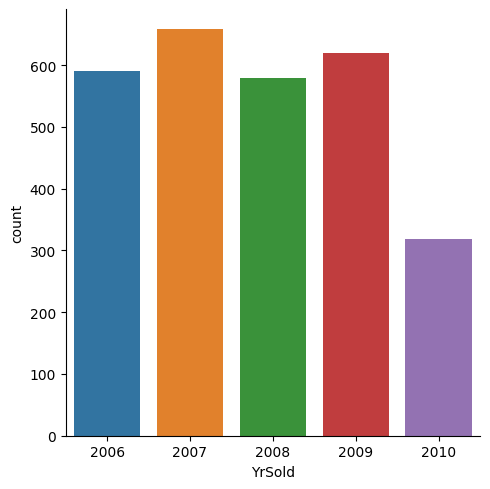

In [51]:
sns.catplot(x="YrSold", kind="count",data=ames)

In [52]:
ames.loc[ames['YrSold'].isin([2006, 2007, 2008])]

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsbShng,AsphShn,BrkCmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod,YearsSince1950GarageBuilt
989,12.081076,20,RL,87.0,11029.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,8,Hip,CompShg,NaN,0.0,Ex,TA,CBlock,Gd,TA,No,ALQ,528.0,BLQ,411.0,245.0,1184.0,GasA,Ex,Y,SBrkr,1414.0,0.0,0.0,1414.0,1,0,1,0,3,1,TA,6,Min1,1,TA,Attchd,Unf,2,601.0,TA,TA,Y,0.0,51.0,0.0,0.0,190.0,0.0,NoPool,NoFence,NaN,0.0,5,2008,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8,52,40.0
990,12.377923,20,RL,0.0,12925.0,Pave,NoAccess,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,1Story,6,7,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,BLQ,865.0,Unf,0.0,340.0,1205.0,GasA,Ex,Y,SBrkr,2117.0,0.0,0.0,2117.0,0,0,2,1,4,1,TA,7,Typ,2,Gd,Attchd,Fin,2,550.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,5,2008,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,20,20,20.0
991,12.239991,60,RL,85.0,11075.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,2Story,6,5,Gable,CompShg,NaN,0.0,TA,TA,CBlock,Fa,TA,Mn,ALQ,500.0,LwQ,276.0,176.0,952.0,GasA,TA,Y,SBrkr,1092.0,1020.0,0.0,2112.0,0,0,2,1,4,1,TA,9,Typ,2,Gd,Attchd,Unf,2,576.0,TA,TA,Y,280.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,6,2008,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,19,19,19.0
992,12.141534,60,RL,72.0,8702.0,Pave,NoAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,6,5,Gable,CompShg,NaN,0.0,TA,TA,PConc,TA,TA,No,BLQ,706.0,Unf,0.0,220.0,926.0,GasA,Ex,Y,SBrkr,926.0,678.0,0.0,1604.0,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,Fin,2,470.0,TA,TA,Y,0.0,36.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,4,2008,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,48,47.0
993,12.013701,60,RL,65.0,8139.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,6,5,Gable,CompShg,BrkFace,119.0,TA,TA,PConc,Gd,TA,No,ALQ,476.0,Unf,0.0,204.0,680.0,GasA,Gd,Y,SBrkr,680.0,790.0,0.0,1470.0,0,0,2,1,3,1,TA,7,Typ,1,TA,BuiltIn,Fin,2,420.0,TA,TA,Y,192.0,49.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,10,2008,WD,Normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,45,46,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,11.782953,20,RL,160.0,20000.0,Pave,NoAccess,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,1Fam,1Story,5,7,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224.0,0.0,0.0,1224.0,1,0,1,0,4,1,TA,7,Typ,1,TA,Detchd,Unf,2,576.0,TA,TA,Y,474.0,0.0,0.0,0.0,0.0,0.0,NoPool,NoFence,NaN,0.0,9,2006,WD,Abnorml,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10,46,10.0
2925,11.867097,80,RL,37.0,7937.0,Pave,NoAccess,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,1Fam,SLvl,6,6,Gable,CompShg,NaN,0.0,TA,TA,CBlock,TA,TA,Av,GL

# In-class activity 3: If we use a categorical variable (for example, `YrSold`), to split the training set and testing set, can we use this categorical variable as a predictor? Why?

No, you cannot split based on the year as splitting by year would bias the model to the year you train it off of.

In [53]:
ames_train = ames.loc[ames['YrSold'].isin([2006, 2007, 2008])]
ames_test = ames.loc[ames['YrSold'].isin([2009, 2010])]

ames = ames.drop(columns = ['YrSold'])
ames_train = ames_train.drop(columns = ['YrSold'])
ames_test = ames_test.drop(columns = ['YrSold'])

print(ames.shape, ames_train.shape, ames_test.shape)

(2765, 104) (1828, 104) (937, 104)


## 2.1 Naive Linear Regression

a) with only original features (without polynomial features)

In [146]:
print(ames_train.shape)
all_columns = "+".join(ames_train.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
print(my_formula)

mod_naive = smf.ols(my_formula, data=ames_train)
nlr = mod_naive.fit()

print(nlr.summary())

(1828, 104)
LogSalePrice~Alley+Artery+AsbShng+AsphShn+BedroomAbvGr+BldgType+BrkCmn+BrkComm+BrkFace+BsmtCond+BsmtExposure+BsmtFinSF1+BsmtFinSF2+BsmtFinType1+BsmtFinType2+BsmtFullBath+BsmtHalfBath+BsmtQual+BsmtUnfSF+CBlock+CemntBd+CentralAir+CmentBd+Electrical+EnclosedPorch+ExterCond+ExterQual+Feedr+Fence+FireplaceQu+Fireplaces+Foundation+FullBath+Functional+GarageArea+GarageCars+GarageCond+GarageFinish+GarageQual+GarageType+GrLivArea+HalfBath+HdBoard+Heating+HeatingQC+HouseStyle+ImStucc+KitchenAbvGr+KitchenQual+LandContour+LandSlope+LotArea+LotConfig+LotFrontage+LotShape+LowQualFinSF+MSSubClass+MSZoning+MasVnrArea+MasVnrType+MetalSd+MiscFeature+MiscVal+MoSold+Neighborhood+Norm+OpenPorchSF+Other+OverallCond+OverallQual+PavedDrive+Plywood+PoolArea+PoolQC+PosA+PosN+PreCast+RRAe+RRAn+RRNe+RRNn+RoofMatl+RoofStyle+SaleCondition+SaleType+ScreenPorch+Stone+Street+Stucco+TotRmsAbvGrd+TotalBsmtSF+Utilities+VinylSd+WdSdng+WdShing+WdShng+WoodDeckSF+X1stFlrSF+X2ndFlrSF+X3SsnPorch+YearsSince1950Built

In [148]:
y_train = ames_train['LogSalePrice']
y_test = ames_test['LogSalePrice']

In [149]:
print_metrics(nlr, ames_train, y_train, ames_test, y_test, flag_log_sale_price = True)
print_metrics(nlr, ames_train, y_train, ames_test, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.9603376376378353
Training MAE 0.056296645864473735
Training RMSE 0.07708753756375214
Out-of-sample R2 0.841606083387815
Out-of-sample MAE 0.08310808994392915
Out-of-sample RMSE 0.15762880433405427

Metrics for Sale Price:

Training R2 0.9617308456632392
Training MAE 10352.437245142204
Training RMSE 15282.418966079205
Out-of-sample R2 0.3685202293380101
Out-of-sample MAE 15719.44135806566
Out-of-sample RMSE 62283.05295004466


# In-class activity 4: Remove some predictors of the linear regression model based on the output. Does the out-of-sample performance get better?

In [162]:
all_columns = "+".join(ames_train.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
my_formula = my_formula.replace("BedroomAbvGr+", "")
print(my_formula)

mod_naive1 = smf.ols(my_formula, data=ames_train)
nlr1 = mod_naive.fit()

print(nlr1.summary())

LogSalePrice~Alley+Artery+AsbShng+AsphShn+BldgType+BrkCmn+BrkComm+BrkFace+BsmtCond+BsmtExposure+BsmtFinSF1+BsmtFinSF2+BsmtFinType1+BsmtFinType2+BsmtFullBath+BsmtHalfBath+BsmtQual+BsmtUnfSF+CBlock+CemntBd+CentralAir+CmentBd+Electrical+EnclosedPorch+ExterCond+ExterQual+Feedr+Fence+FireplaceQu+Fireplaces+Foundation+FullBath+Functional+GarageArea+GarageCars+GarageCond+GarageFinish+GarageQual+GarageType+GrLivArea+HalfBath+HdBoard+Heating+HeatingQC+HouseStyle+ImStucc+KitchenAbvGr+KitchenQual+LandContour+LandSlope+LotArea+LotConfig+LotFrontage+LotShape+LowQualFinSF+MSSubClass+MSZoning+MasVnrArea+MasVnrType+MetalSd+MiscFeature+MiscVal+MoSold+Neighborhood+Norm+OpenPorchSF+Other+OverallCond+OverallQual+PavedDrive+Plywood+PoolArea+PoolQC+PosA+PosN+PreCast+RRAe+RRAn+RRNe+RRNn+RoofMatl+RoofStyle+SaleCondition+SaleType+ScreenPorch+Stone+Street+Stucco+TotRmsAbvGrd+TotalBsmtSF+Utilities+VinylSd+WdSdng+WdShing+WdShng+WoodDeckSF+X1stFlrSF+X2ndFlrSF+X3SsnPorch+YearsSince1950Built+YearsSince1950GarageBuil

The out of order sample gets better with the removal those featues.

b) with polynomial features

### Higher-order Variables

We can construct new features using a polynomial transformation. This is necessary because the regression plots we generated with 'LogSalePrice ~ [single independent variable]' exhibits some non-linear relationship. In the function below, you can choose the highest degree of the polynomial features. A higher degree polynomial might cause overfitting concern, but we will later use 'regularization' to mitigate this issue. 


In [163]:
def create_polynomial_features(df, n_degree):

    new_df = None
    
    for i in range(2, n_degree+1):
        
        tmp = df.pow(i)
        
        affix = '_p'+str(i)
        tmp.columns = list(map(lambda x: x + affix, df.columns))
        
        if new_df is not None:
            new_df = pd.concat([new_df, tmp], axis=1)
        else:
            new_df = tmp
    
    return new_df

<span style='color:blue'>
    
NOTE: An important consideration when creating higher-order variables is that the resulting features will tend to have some degree of linear dependence amongst themselves. This is normal as several new features are based on their zero-th power peer. Such correlation can also yield a high degree of multicollinearity in the regression models. The `sklearn` implementations that we will be using do not automatically account for this phenomenon, therefore we must be careful in selection the `n_degree`, and analyzing the model fit. 

</span>

In [164]:
# We only choose a select list of variables to do polynomial transformation.
poly_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
             'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
             'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'MiscVal', 'YearsSince1950Built',
             'YearsSince1950Remod', 'YearsSince1950GarageBuilt']

In [165]:
n_degree = 2

train_poly_temp = create_polynomial_features(ames_train[poly_cols], n_degree)
test_poly_temp = create_polynomial_features(ames_test[poly_cols], n_degree)

ames_train_poly = pd.concat([ames_train, train_poly_temp], axis=1)
ames_test_poly = pd.concat([ames_test, test_poly_temp], axis=1)

print(ames_train.shape, ames_test.shape)
print(train_poly_temp.shape, test_poly_temp.shape)
print(ames_train_poly.shape, ames_test_poly.shape)

(1828, 104) (937, 104)
(1828, 21) (937, 21)
(1828, 125) (937, 125)


In [132]:
print(ames_train_poly.shape)
all_columns = "+".join(ames_train_poly.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
print(my_formula)

mod_naive_poly = smf.ols(my_formula, data=ames_train_poly)
nlr_poly = mod_naive_poly.fit()

print(nlr_poly.summary())

(1828, 125)
LogSalePrice~Alley+Artery+AsbShng+AsphShn+BedroomAbvGr+BldgType+BrkCmn+BrkComm+BrkFace+BsmtCond+BsmtExposure+BsmtFinSF1+BsmtFinSF1_p2+BsmtFinSF2+BsmtFinSF2_p2+BsmtFinType1+BsmtFinType2+BsmtFullBath+BsmtHalfBath+BsmtQual+BsmtUnfSF+BsmtUnfSF_p2+CBlock+CemntBd+CentralAir+CmentBd+Electrical+EnclosedPorch+EnclosedPorch_p2+ExterCond+ExterQual+Feedr+Fence+FireplaceQu+Fireplaces+Foundation+FullBath+Functional+GarageArea+GarageArea_p2+GarageCars+GarageCond+GarageFinish+GarageQual+GarageType+GrLivArea+GrLivArea_p2+HalfBath+HdBoard+Heating+HeatingQC+HouseStyle+ImStucc+KitchenAbvGr+KitchenQual+LandContour+LandSlope+LotArea+LotArea_p2+LotConfig+LotFrontage+LotFrontage_p2+LotShape+LowQualFinSF+LowQualFinSF_p2+MSSubClass+MSZoning+MasVnrArea+MasVnrArea_p2+MasVnrType+MetalSd+MiscFeature+MiscVal+MiscVal_p2+MoSold+Neighborhood+Norm+OpenPorchSF+OpenPorchSF_p2+Other+OverallCond+OverallQual+PavedDrive+Plywood+PoolArea+PoolQC+PosA+PosN+PreCast+RRAe+RRAn+RRNe+RRNn+RoofMatl+RoofStyle+SaleCondition+

In [133]:
print_metrics(nlr_poly, ames_train_poly, y_train, ames_test_poly, y_test, flag_log_sale_price = True)
print_metrics(nlr_poly, ames_train_poly, y_train, ames_test_poly, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.9624105774712388
Training MAE 0.05428716093205558
Training RMSE 0.0750460279888416
Out-of-sample R2 0.8389619917903268
Out-of-sample MAE 0.08377530870649239
Out-of-sample RMSE 0.1589390188028398

Metrics for Sale Price:

Training R2 0.9640398519644913
Training MAE 9959.939035658694
Training RMSE 14814.206850762086
Out-of-sample R2 0.4282527691320738
Out-of-sample MAE 15888.48471150965
Out-of-sample RMSE 59264.169943559464


<span style='color:blue'>
    
 Pay attention to the test set performance.

</span>

## 2.2 "Common Sense" Linear Regression

We want to perform linear regression with only some of the variables which could be chosen using common sense

In [134]:
ames_train[['MSSubClass', 'OverallQual','YearsSince1950Built','GrLivArea','TotRmsAbvGrd','FullBath','SaleCondition']]

,MSSubClass,OverallQual,YearsSince1950Built,GrLivArea,TotRmsAbvGrd,FullBath,SaleCondition
989,20,6,8,1414.0,6,1,Normal
990,20,6,20,2117.0,7,2,Normal
991,60,6,19,2112.0,9,2,Normal
992,60,6,47,1604.0,7,2,Normal
993,60,6,45,1470.0,7,2,Normal
...,...,...,...,...,...,...,...
2924,20,5,10,1224.0,7,1,Abnorml
2925,80,6,34,1003.0,6,1,Normal
2926,20,5,33,902.0,5,1,Normal
2928,20,5,24,1389.0,6,1,Normal


In [166]:
ames_train_cs = ames_train[['LogSalePrice','MSSubClass', 'OverallQual','YearsSince1950Built','GrLivArea','TotRmsAbvGrd','FullBath','SaleCondition']]
ames_train_cs = ames_train_cs.copy()
ames_train_cs['OverallQual'] = ames_train_cs['OverallQual'].astype('float') 
ames_train_cs['TotRmsAbvGrd'] = ames_train_cs['TotRmsAbvGrd'].astype('int') 
ames_train_cs['FullBath'] = ames_train_cs['FullBath'].astype('int') 


ames_test_cs = ames_test[['LogSalePrice','MSSubClass', 'OverallQual','YearsSince1950Built','GrLivArea','TotRmsAbvGrd','FullBath','SaleCondition']]
ames_test_cs = ames_test_cs.copy()
ames_test_cs['OverallQual'] = ames_test_cs['OverallQual'].astype('float') 
ames_test_cs['TotRmsAbvGrd'] = ames_test_cs['TotRmsAbvGrd'].astype('int') 
ames_test_cs['FullBath'] = ames_test_cs['FullBath'].astype('int') 


print(ames_train_cs.shape)

(1828, 8)


In [136]:

all_columns = "+".join(ames_train_cs.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
print(my_formula)

mod_commonsense = smf.ols(my_formula, data=ames_train_cs)
lr_cs = mod_commonsense.fit()

print(lr_cs.summary())

LogSalePrice~FullBath+GrLivArea+MSSubClass+OverallQual+SaleCondition+TotRmsAbvGrd+YearsSince1950Built-1
                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     437.4
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:53:01   Log-Likelihood:                 928.68
No. Observations:                1828   AIC:                            -1805.
Df Residuals:                    1802   BIC:                            -1662.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [137]:
print_metrics(lr_cs, ames_train_cs, y_train, ames_test_cs, y_test, flag_log_sale_price = True)
print_metrics(lr_cs, ames_train_cs, y_train, ames_test_cs, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8585288469181493
Training MAE 0.10592319141714
Training RMSE 0.14558908973890203
Out-of-sample R2 0.8347117625902264
Out-of-sample MAE 0.11370443708305598
Out-of-sample RMSE 0.16102277494361028

Metrics for Sale Price:

Training R2 0.8752645912587628
Training MAE 19392.02270765297
Training RMSE 27590.68901979693
Out-of-sample R2 0.867283831485725
Out-of-sample MAE 19917.23592522733
Out-of-sample RMSE 28553.022575225714


# Part 2: Model refinement

## 1. Principal Components Regression

We first remove columns that are nearly constant, i.e., have small standard deviation. Then we use sklearn grid-search for cross validation and finally retrain the final model.  

In [138]:
X_train_poly = ames_train_poly.drop(columns='LogSalePrice')
X_test_poly = ames_test_poly.drop(columns='LogSalePrice')

X_train_poly_wide = pd.get_dummies(X_train_poly)
X_test_poly_wide = pd.get_dummies(X_test_poly)

In [139]:
y_train = ames_train['LogSalePrice']
y_test = ames_test['LogSalePrice']

X_train_pcr = X_train_poly_wide.loc[:, X_train_poly_wide.std() > 0.1]
X_test_pcr = X_test_poly_wide[X_train_pcr.columns]

print(X_train_poly_wide.shape, X_train_pcr.shape)
print(X_test_poly_wide.shape, X_test_pcr.shape)

(1828, 397) (1828, 275)
(937, 397) (937, 275)


We also standardize the data before feeding it to the PCA step, as recommended by good practice.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
pca = PCA(n_components=5, random_state=88)
lr = LinearRegression()r
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('lr', lr)])

pipe.fit(X_train_pcr, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=5, random_state=88)),
                ('lr', LinearRegression())])

In [141]:
print_metrics(pipe, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = True)
print_metrics(pipe, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8567244094773699
Training MAE 0.1010869942210609
Training RMSE 0.14651462829012943
Out-of-sample R2 0.8355568543382659
Out-of-sample MAE 0.10530967892420576
Out-of-sample RMSE 0.16061060586244824

Metrics for Sale Price:

Training R2 0.8927975509686595
Training MAE 17757.429598137704
Training RMSE 25578.202564553932
Out-of-sample R2 0.8987227159041018
Out-of-sample MAE 17636.54874599874
Out-of-sample RMSE 24942.85685699089


## 2. Ridge Regression

We can choose `alpha_max` so as the value that makes all coefficientes zero, and then construct a log sequence of `alpha` values trending smaller, decreasing the degree of regularization. 

For the case of `Ridge` Regression, alpha value that would make all coefficients zero would be `Inf`, however we can be satisfied with sufficiently small numbers, and work from there.

In [142]:
X_train_rr = X_train_poly_wide
X_test_rr = X_test_poly_wide

print(X_train_rr.shape, X_test_rr.shape)

(1828, 397) (937, 397)


### Determine 'alpha_max'

In [143]:
from sklearn.linear_model import Ridge

alpha_max = 10**5
rr = Ridge(alpha=alpha_max, random_state=88)
rr.fit(X_train_rr, y_train)

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.87405e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=100000, random_state=88)

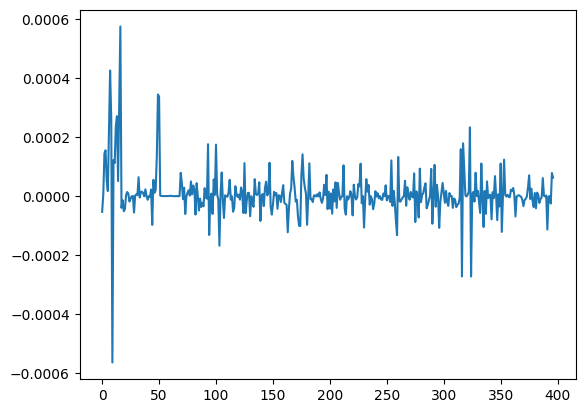

0.0005755966628195391


In [144]:
plt.plot(rr.coef_)
plt.show()
print(max(abs(rr.coef_)))

In [145]:
print_metrics(rr, X_train_rr, y_train, X_test_rr, y_test, flag_log_sale_price = True)
print_metrics(rr, X_train_rr, y_train, X_test_rr, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8452590849089253
Training MAE 0.10467969125067748
Training RMSE 0.1522640805932089
Out-of-sample R2 0.8229399441245376
Out-of-sample MAE 0.11151022706827882
Out-of-sample RMSE 0.1666581785089057

Metrics for Sale Price:

Training R2 0.8782379768912658
Training MAE 18648.761649168955
Training RMSE 27259.858467714057
Out-of-sample R2 0.8695106549024978
Out-of-sample MAE 19389.607748338763
Out-of-sample RMSE 28312.465936143166


## 3. Lasso Regression

In [73]:
from sklearn.linear_model import Lasso

In [71]:
X_train_lasso = X_train_poly_wide
X_test_lasso = X_test_poly_wide

print(X_train_lasso.shape, X_test_lasso.shape)

(1828, 397) (937, 397)


### Lasso Coefficients vs. Degree of Regularization

In [72]:
# Question: What is the best value of lambda in Lasso?

### Lasso Hyper-parameter Tuning

In [73]:
alphas = np.logspace(-5, 1 , num=50, base=10)
coefs = []

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.418e+00, tolerance: 2.739e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.499e+00, tolerance: 2.739e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

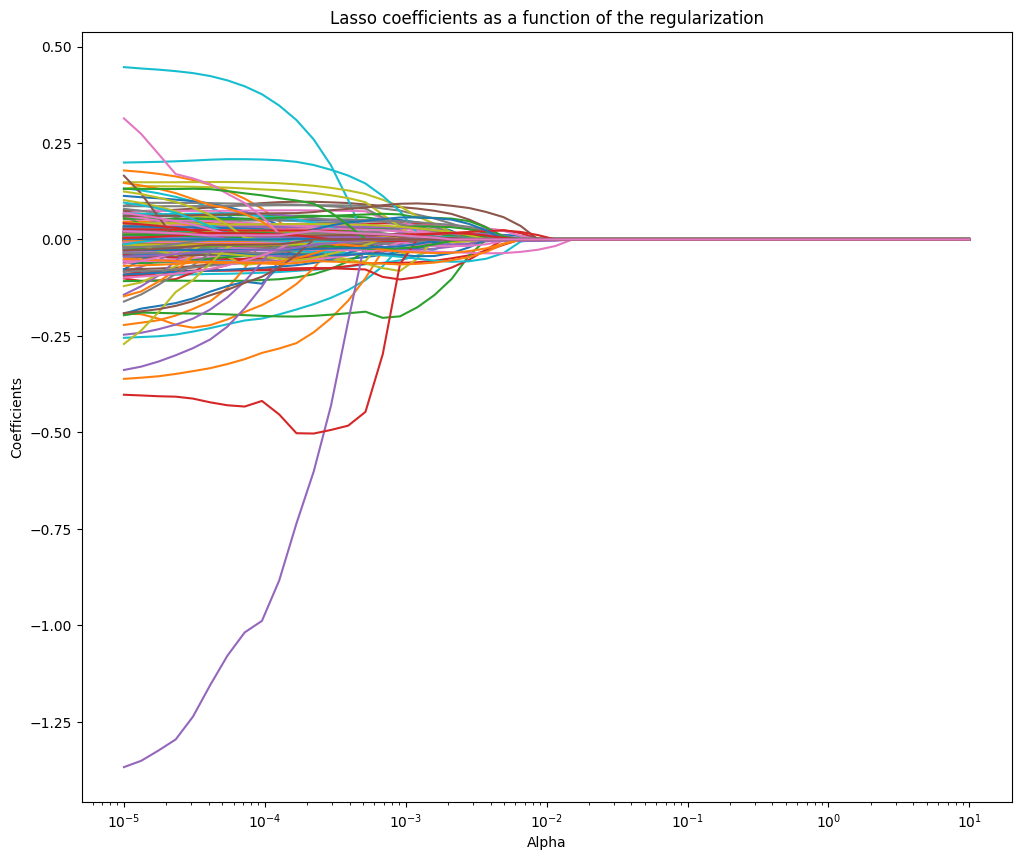

In [74]:
from sklearn.linear_model import Lasso

for a in alphas:
    lasso = Lasso(alpha=a, random_state=88)
    lasso.fit(X_train_lasso, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(12, 10))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.show()

### Selected Variables

Let's look at some of the variables selected by lasso

In [75]:
lasso = Lasso(alpha=0.1, random_state=88)
lasso.fit(X_train_lasso, y_train)

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e+01, tolerance: 2.739e-02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1, random_state=88)

In [76]:
cols = X_train_lasso.columns
coefs = lasso.coef_
sorted(zip(abs(coefs), cols))

[(0.0, 'Alley_Grvl'),
 (0.0, 'Alley_NoAccess'),
 (0.0, 'Alley_Pave'),
 (0.0, 'Artery'),
 (0.0, 'AsbShng'),
 (0.0, 'AsphShn'),
 (0.0, 'BedroomAbvGr_0'),
 (0.0, 'BedroomAbvGr_1'),
 (0.0, 'BedroomAbvGr_2'),
 (0.0, 'BedroomAbvGr_3'),
 (0.0, 'BedroomAbvGr_4'),
 (0.0, 'BedroomAbvGr_5'),
 (0.0, 'BedroomAbvGr_6'),
 (0.0, 'BldgType_1Fam'),
 (0.0, 'BldgType_2fmCon'),
 (0.0, 'BldgType_Duplex'),
 (0.0, 'BldgType_Twnhs'),
 (0.0, 'BldgType_TwnhsE'),
 (0.0, 'BrkCmn'),
 (0.0, 'BrkComm'),
 (0.0, 'BrkFace'),
 (0.0, 'BsmtCond_Ex'),
 (0.0, 'BsmtCond_Fa'),
 (0.0, 'BsmtCond_Gd'),
 (0.0, 'BsmtCond_NaN'),
 (0.0, 'BsmtCond_NoBasement'),
 (0.0, 'BsmtCond_Po'),
 (0.0, 'BsmtCond_TA'),
 (0.0, 'BsmtExposure_Av'),
 (0.0, 'BsmtExposure_Gd'),
 (0.0, 'BsmtExposure_Mn'),
 (0.0, 'BsmtExposure_NaN'),
 (0.0, 'BsmtExposure_No'),
 (0.0, 'BsmtExposure_NoBasement'),
 (0.0, 'BsmtFinType1_ALQ'),
 (0.0, 'BsmtFinType1_BLQ'),
 (0.0, 'BsmtFinType1_GLQ'),
 (0.0, 'BsmtFinType1_LwQ'),
 (0.0, 'BsmtFinType1_NaN'),
 (0.0, 'BsmtFinType1_No

In [77]:
print_metrics(rr, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(rr, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8452590849089253
Training MAE 0.10467969125067748
Training RMSE 0.1522640805932089
Out-of-sample R2 0.8229399441245376
Out-of-sample MAE 0.11151022706827882
Out-of-sample RMSE 0.1666581785089057

Metrics for Sale Price:

Training R2 0.8782379768912658
Training MAE 18648.761649168955
Training RMSE 27259.858467714057
Out-of-sample R2 0.8695106549024978
Out-of-sample MAE 19389.607748338763
Out-of-sample RMSE 28312.465936143166
